<div class='container' style='border-bottom: 1px solid; width:100%'>
    <div style='float:left'>
    Bernat Esquirol & Pere Gilabert 
    </div>
    <div style='float:right'>
    Complex Networks 2019
    </div>
</div>

# Delivery 01: Visualization and Metrics

## Data

The data we've used to build our network are Spotify bands and playlists. Through API calls we have managed to download about 20,000 playlists with the respective artists performing each of the songs.

As a result, there are two different types of nodes in this network:
* Playlist node
* Artist node

Since we have these two types of nodes, we have built a bipartite graph. 

## Graph

### Read the data

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from matplotlib import pyplot as plt

%matplotlib inline

songs = pd.read_pickle('../data/songs.pkl')
songs['artist']=songs['artists'].apply(lambda x: x[0][1])
playlists = pd.read_pickle('../data/final_spotify_playlists.pkl')

### Creating the graph

In [4]:
# Create a default graph
spotify = nx.Graph()

# Read the playlists from a file
playlists = pd.read_pickle('../data/final_spotify_playlists.pkl')

print("{:d} playlists ready to be added to the network".format(len(playlists.index)))

# We add two different types of nodes 
spotify.add_nodes_from(playlists.index, bipartite=0)
spotify.add_nodes_from(songs['artist'].unique(), bipartite=1)

# The edges are created here
print("Adding nodes...", end="")
for artist, group in songs[['artist','playlists']].groupby('artist'):
    for playlists in group['playlists'].values:
        for playlist in playlists:
            spotify.add_edge(artist, playlist)
print("DONE")

# Remove lonely nodes
spotify.remove_nodes_from(list(nx.isolates(spotify)))

print("\nFinal graph has {:d} nodes and {:d} edges".format(len(spotify.nodes), len(spotify.edges)))

20929 playlists ready to be added to the network
Adding nodes...DONE

Final graph has 83759 nodes and 307183 edges


### Prunning the graph

As we have a huge bipartite network, we project over artists, so that the remaining graph has as nodes all the playlists (6387), and weighted edges as how many artists they share.

In [4]:
from networkx.algorithms import bipartite
# spotify = nx.read_gpickle('../data/network_bipartite.gpkl')

In [6]:
spotify_big_connected = spotify.subgraph(next(nx.connected_components(spotify)))
playlists, artists = bipartite.sets(spotify_big_connected)

In [13]:
# playlists_projection = bipartite.weighted_projected_graph(spotify_big_connected, playlists)
playlists_projection = nx.read_gpickle('../data/playlists_projection.gpkl')

In [15]:
len(playlists_projection)

6387

Now for example we can retrieve the most similar playlist from another playlist has the most weighted neighbor

In [17]:
def get_nearest(projection, id_playlist):
    neighbors = playlists_projection.neighbors(id_playlist)
    tal = [(projection[id_playlist][id_n]['weight'],id_n,playlists.loc[id_n]) for id_n in neighbors]
    return sorted(tal, reverse=True)

In [19]:
# 37i9dQZF1DX0SM0LYsmbMT Jazz Vibes
get_nearest(playlists_projection, '37i9dQZF1DX0SM0LYsmbMT')[:10]

[(44, '37i9dQZF1DWWQRwui0ExPn', 'Lo-Fi Beats'),
 (23, '37i9dQZF1DX8Uebhn9wzrS', 'Chill Lofi Study Beats'),
 (16, '37i9dQZF1DX3qCx5yEZkcJ', 'Mellow Beats'),
 (15, '37i9dQZF1DX9RwfGbeGQwP', 'Lo-Fi Cafe'),
 (13, '37i9dQZF1DXc8kgYqQLMfH', 'Lush Lofi'),
 (12, '37i9dQZF1DX36Xw4IJIVKA', 'Lofi Hip-Hop'),
 (12, '37i9dQZF1DWXHS0n2OcMjx', 'Homework Beats'),
 (11, '37i9dQZF1DWYoYGBbGKurt', 'Chill Instrumental Beats'),
 (10, '37i9dQZF1DXdipfKDeMPTE', 'Moonlight Bumps'),
 (10, '37i9dQZF1DXbtuVQL4zoey', 'Sunny Beats')]

### Plotting the graph

In [15]:
# nx.draw(playlists_projection)

## Metrics

### Degree centrality

In [20]:
deg_central = nx.degree_centrality(playlists_projection)
deg_central_sorted = [(k, v) for k, v in sorted(deg_central.items(), key=lambda item: item[1])]

In [21]:
print("The less connected node is {:s} with {:d} "\
      "connections and a degree centrality of {:f}".format(deg_central_sorted[0][0], 
                                                           len(playlists_projection.edges([deg_central_sorted[0][0]])),
                                                           deg_central_sorted[0][1]))
print("The most connected node is {:s} with {:d} "\
      "connections and a degree centrality of {:f}".format(deg_central_sorted[-1][0], 
                                                           len(playlists_projection.edges([deg_central_sorted[-1][0]])),
                                                           deg_central_sorted[-1][1]))

The less connected node is 37i9dQZF1DWYLzS1pepUTD with 1 connections and a degree centrality of 0.000157
The most connected node is 37i9dQZF1DWTmvXBN4DgpA with 3393 connections and a degree centrality of 0.531319


### Degree's distribution

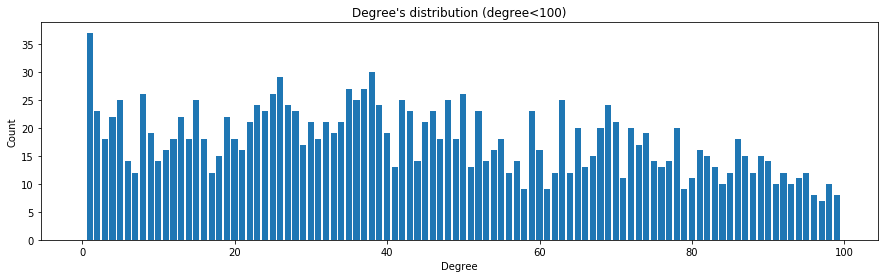

In [22]:
LIMIT = 100

degrees = nx.degree_histogram(playlists_projection)[:LIMIT]
plt.figure(figsize=(15,4))
plt.bar(list(range(len(degrees))),degrees)
plt.title('Degree\'s distribution (degree<{:d})'.format(LIMIT))
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()

### Diameter (length of the maximum path)

In [28]:
diameter = nx.diameter(playlists_projection)

In [ ]:
%time print("{:f}".format(diameter))

### Closeness centrality

In [27]:
# %time closeness = nx.closeness_centrality(playlists_projection)
# closeness_sorted = [(k, v) for k, v in sorted(closeness.items(), key=lambda item: item[1])]

In [24]:
print("The node with the lowest closeness value is {:s} with a value of {:f}".format(closeness_sorted[0][0], 
                                                           closeness_sorted[0][1]))
print("The node with the highest closeness value is {:s} with a value of {:f}".format(closeness_sorted[-1][0], 
                                                           closeness_sorted[-1][1]))

NameError: name 'closeness_sorted' is not defined

### Betweeness centrality

In [ ]:
%time between = nx.betweenness_centrality(playlists_projection)
between_sorted = [(k, v) for k, v in sorted(between.items(), key=lambda item: item[1])]

In [29]:
print("The node with the lowest betweeness value is {:s} with a value of {:f}".format(between_sorted[0][0], 
                                                           between_sorted[0][1]))
print("The node with the lowest betweeness value is {:s} with a value of {:f}".format(between_sorted[-1][0], 
                                                           between_sorted[-1][1]))

The node with the lowest betweeness value is 0f5nVCcR06GX8Qikz0COtT with a value of 0.000000
The node with the lowest betweeness value is 37i9dQZF1DX14l44D8IaLa with a value of 0.090416
